In [4]:
from ete3 import Tree
import networkx as nx 
import pandas as pd 
import numpy as np
from functools import reduce
from tqdm import tqdm_notebook
import pickle as pic 

from collections import OrderedDict, defaultdict

import scipy.stats as scs
import seaborn as sns; sns.set()

import matplotlib.pyplot as plt
import matplotlib.colors as colors

import sys
import os 

import scipy as sp
from scipy.linalg import eig 
import matplotlib


from contextlib import suppress

import itertools

from tqdm import tqdm

import cassiopeia.TreeSolver.post_process_tree as ppt
import cassiopeia.Analysis.reconstruct_states
from cassiopeia.TreeSolver.Node import Node
import cassiopeia.TreeSolver.compute_meta_purity as cmp

from utilities import seeding_cascades


from sklearn.manifold import MDS, TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import umap
import numba


## Read in lineage groups

In [2]:
lg_meta = pd.read_csv("/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/RNA/LG_meta.txt", sep='\t', index_col = 0)

home_dir = '/data/yosef2/users/mattjones/projects/metastasis/JQ19/5k/trees/'


lg_to_tree = {}
lg_to_cm = {}
for tree_dir in tqdm(os.listdir(home_dir)):
    tree_dir = home_dir + tree_dir + "/"

    if not os.path.isdir(tree_dir):
        continue
    
    lg = tree_dir.split("/")[-2][2:]
    fps = [fp for fp in os.listdir(tree_dir) if "alleleThresh.pkl" in fp and "tree" in fp and 'nj' not in fp]
    cms = [fp for fp in os.listdir(tree_dir) if 'character_matrix.alleleThresh.txt' in fp]
    
    if lg == '5':
        print(fps[0])
    if len(fps) > 0:
        
        try:
            tree = pic.load(open((tree_dir + fps[0]), 'rb'))
            lg_to_tree[int(lg)] = tree
            
            lg_to_cm[int(lg)] = pd.read_csv(tree_dir + cms[0], sep='\t', index_col = 0)
        except:
            continue

 35%|███▍      | 39/113 [00:31<00:33,  2.20it/s]

lg5_tree_hybrid_priorsalleleThresh.pkl


100%|██████████| 113/113 [01:44<00:00,  1.08it/s]


## Form Transition Matrices

In [9]:
count_arrs = []
lgs = []
diag_density = []
LL_density = []
M1_density = []
M2_density = []
LL_stay = []
RW_stay = []
RE_stay = []
Liv_stay = []
M1_stay = []
M2_stay = []

seeding_cascade = {}
reseeding = {}
to_drop = [33, 5, 69, 39, 38, 41, 75, 16, 18, 50, 53, 87, 88, 25, 93, 65, 81]

for _lg in tqdm(lg_to_tree.keys()):
    
    if _lg in to_drop:
        continue
    
    try:
        lg = lg_to_tree[_lg]
        cm = lg_to_cm[_lg]
        
        plg = lg.post_process(cm).network
        
        reseeding[_lg] = seeding_cascades.detect_reseeding(plg, lg_meta['sampleID'])
        seeding_cascade[_lg] = seeding_cascades.detect_seeding_cascade(plg, lg_meta['sampleID'])
        
        count_arr = reconstruct_states.fitch_count(plg, lg_meta['sampleID'], count_unique = False)
        tot = np.sum(count_arr.sum())
        diag_density.append(np.sum([count_arr.iloc[i, i] / tot for i in range(count_arr.shape[0])]))
        
        LL_stay.append(count_arr.loc['LL', "LL"] / tot)
        RW_stay.append(count_arr.loc['RW', "RW"] / tot)
        RE_stay.append(count_arr.loc['RE', "RE"] / tot)
        M1_stay.append(count_arr.loc['M1', "M1"] / tot)
        M2_stay.append(count_arr.loc['M2', "M2"] / tot)
        Liv_stay.append(count_arr.loc['Liv', "Liv"] / tot)
        
        # np.fill_diagonal(count_arr.values,0)
        tot = np.sum(count_arr.sum())
        LL_density.append(np.sum([count_arr.loc['LL', i] / tot for i in count_arr.columns]))
        M1_density.append(np.sum([count_arr.loc['M1', i] / tot for i in count_arr.columns]))
        M2_density.append(np.sum([count_arr.loc['M2', i] / tot for i in count_arr.columns]))
        
        count_arr = count_arr.apply(lambda x: x / max(1, x.sum()), axis=1)
            
        count_arrs.append(count_arr)
        lgs.append(_lg)
               
    except:
        print(_lg)
        
        
    

100%|██████████| 100/100 [04:36<00:00,  2.77s/it]


In [ ]:
# create a dataframe to track different topologies
topo_df = pd.DataFrame(index = lgs)
topo_df['PrimarySeeding'] = False
topo_df['SeedingCascade'] = False
topo_df['ParallelSeeding'] = False
topo_df['Reseeding'] = False
topo_df['BiDirectionalReseeding'] = False
topo_df['ExSeedingCascade'] = None
topo_df['ExReseeding'] = None

for n in lgs:
    transmat = lg_to_countarr[n]
    
    # record seeding cascade
    topo_df.loc[n, 'SeedingCascade'] = seeding_cascade[n][0]
    topo_df.loc[n, 'ExSeedingCascade'] = str(seeding_cascade[n][1])
    
    topo_df.loc[n, 'BiDirectionalReseeding'] = str(reseeding[n][0])
    topo_df.loc[n, 'ExReseeding'] = str(reseeding[n][1])
    
    # detect reseeding
    if np.sum(transmat['LL']) > 0:
        topo_df.loc[n, 'Reseeding'] = True
        topo_df.loc[n, 'BiDirectionalReseeding'] = True
        
    # record primary seeding
    if np.sum(transmat.sum()) > 0 or ("LL" not in lg_meta.loc[lg_meta['LineageGroup'] == n, 'sampleID'].unique()):
        topo_df.loc[n, 'PrimarySeeding'] = True
        
    # record parallel seeding
    for i in transmat.index:
        dens_arr = np.where(transmat.loc[i] > 0)[0]
        if len(dens_arr) > 1:
            topo_df.loc[n, 'ParallelSeeding'] = True
            
# topo_df.to_csv("lineage_topology.5k.txt", sep='\t')

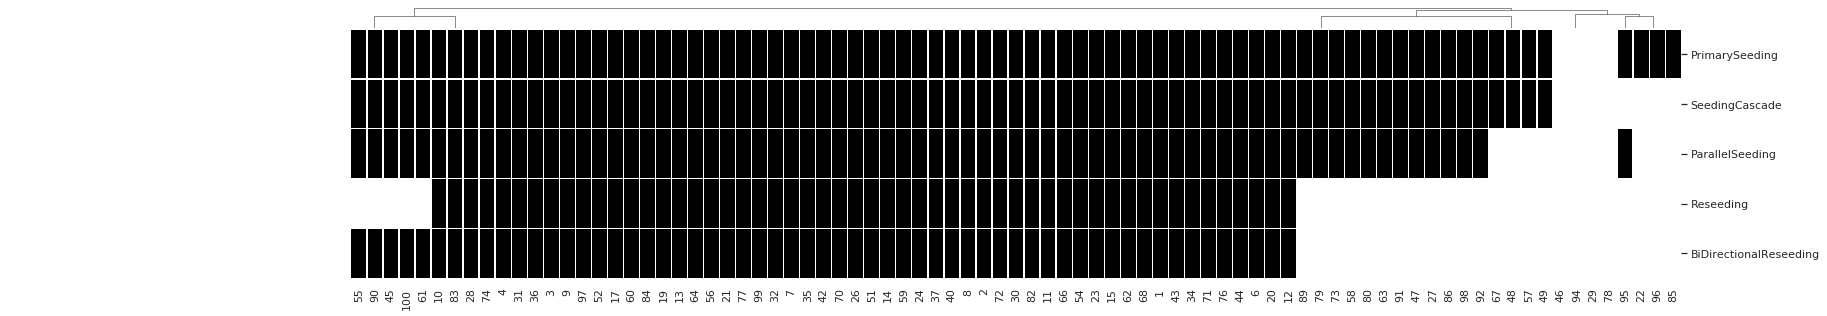

In [11]:
topo_df = pd.read_csv("data/5k/lineage_topology.5k.txt", sep='\t', index_col = 0)

sns.set(font_scale=1)
topo_df = topo_df.iloc[:, :5]
cm = sns.clustermap(topo_df.T, cmap = 'Greys', row_cluster=False, figsize = (30, 5), linewidths=.25)
cm.cax.set_visible(False) 

# plt.savefig('lineage_topology.5k.eps')

## Summarize transition matrices

In [546]:
# unravel and drop diagonal values
transition_vectors = []
lgs = []
k = 0
for lg, tm in lg_to_countarr.items():
    tv = []
        
    lgs.append(lg)
    for i in range(tm.shape[0]):
        for j in range(tm.shape[1]):
            tv.append(tm.iloc[i, j])
    tv.append(np.sum(tm['LL'].values))
    tv.append(np.sum(tm[['M1', 'M2']].sum()))
    tv.append(np.sum(tm['Liv'].values))
    tv.append(np.sum(tm.loc['LL', ['RW', 'RE']].sum()))
    tv.append(np.sum(tm.loc[['RE', 'RW'], 'LL'].sum()))
    tv.append(np.sum(tm.loc[['LL', "RE", "RW"], ['LL', 'RE', 'RW']].sum()))
    tv.append(np.sum(tm.loc[['M1', 'M2'], ['M1', 'M2']].sum()))
    tv.append(np.sum(tm[['RE', 'RW']].sum()))
    tv.append(LL_density[k])
    tv.append(M1_density[k])
    tv.append(M2_density[k])
    tv.append(M1_density[k] + M2_density[k])
    tv.append(diag_density[k])
#     tv.append(LL_stay[k])
#     tv.append(RW_stay[k])
#     tv.append(RE_stay[k])
#     tv.append(M1_stay[k])
#     tv.append(M2_stay[k])
#     tv.append(Liv_stay[k])
    transition_vectors.append(np.nan_to_num(tv))
    
    k += 1

tmat = np.array(transition_vectors)

trans_labels = []
toy = lg_to_countarr[1]
for i in range(toy.shape[0]):
    for j in range(toy.shape[1]):
        trans_labels.append(toy.index.values[i] + "->" + toy.columns.values[j])
trans_labels.append("LLReseeding")
trans_labels.append("To_M")
trans_labels.append('To_Liv')
trans_labels.append('LL_to_RL')
trans_labels.append("RL_to_LL")
trans_labels.append("IntraLung")
trans_labels.append('IntraM')
trans_labels.append('ToRL')
trans_labels.append("PrimarySeeding")
trans_labels.append("FromM1")
trans_labels.append("FromM2")
trans_labels.append("FromMed")
trans_labels.append('DiagDensity')
# trans_labels.append('LLSelf')
# trans_labels.append('RWSelf')
# trans_labels.append('RESelf')
# trans_labels.append('M1Self')
# trans_labels.append('M2Self')
# trans_labels.append('LivSelf')

tmat = pd.DataFrame(tmat)

tmat_z = tmat \
    .subtract(tmat.mean(axis=1), axis=0) \
    .divide(tmat.std(axis=1), axis=0)

tmat_z = np.nan_to_num(tmat_z)

pca = PCA()
tmat_transformed = pca.fit_transform(tmat_z)

0.6769482122111866


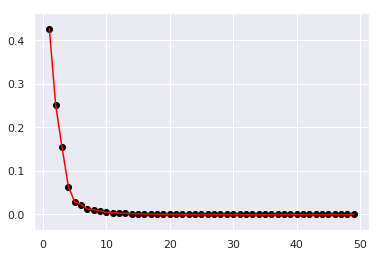

'PrimarySeeding'

In [547]:
loadings = np.transpose(pca.components_[0:2, :])
var_explained = pca.explained_variance_ratio_

plt.scatter(np.arange(1, len(var_explained)+1), var_explained, color='black')
plt.plot(np.arange(1, len(var_explained)+1), var_explained, color='red')
plt.show()

pc1_top_loading = np.argmax(loadings[:,0])
pc2_top_loading = np.argmax(loadings[:,1])

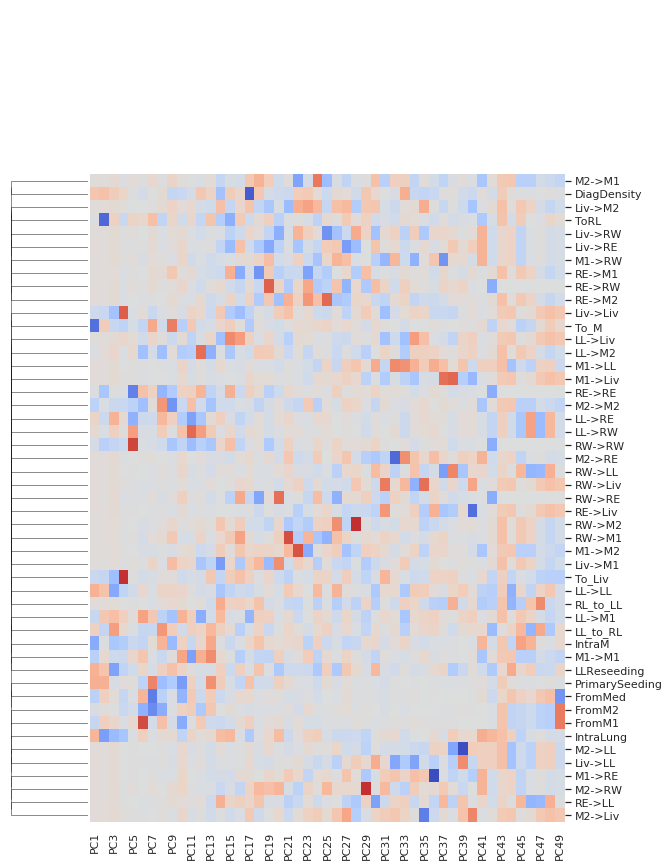

(49, 49)


,PC1,PC2,PC3
To_M,-0.606250,0.127734,-0.111141
IntraM,-0.383102,-0.005199,-0.233670
M1->M1,-0.181677,0.049811,-0.080478
FromMed,-0.169337,0.107491,0.023708
M2->M2,-0.161728,-0.023296,-0.099294
FromM1,-0.117774,0.114780,0.066655
LL->M1,-0.110692,0.165655,0.209057
To_Liv,-0.097685,-0.117170,-0.283744
Liv->Liv,-0.076792,-0.104889,-0.270794
RW->RW,-0.043140,-0.175456,-0.125056


In [551]:
coeff = np.transpose(pca.components_)
coeffdf = pd.DataFrame(coeff, index=trans_labels)
coeffdf.columns = ["PC" + str(x + 1) for x in range(coeff.shape[1])]

cm = sns.clustermap(coeffdf, cmap = 'coolwarm', col_cluster=False, figsize = (10, 15), center=0)
cm.cax.set_visible(False)
# plt.savefig('transmatpca_loadings.ALL.eps')
plt.show()

print(coeffdf.shape)
coeffdf.iloc[:,:3].sort_values(by = 'PC1')

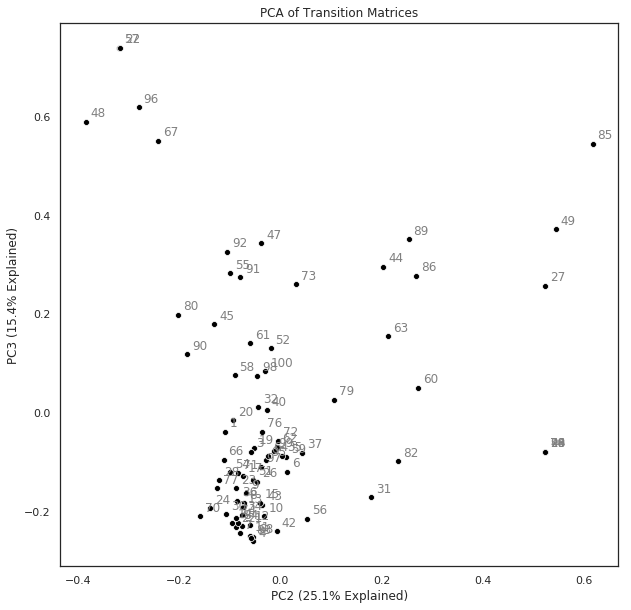

9


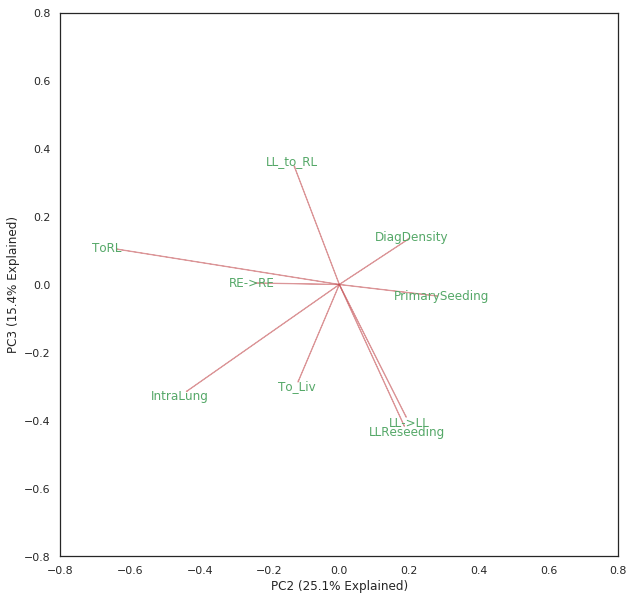

In [550]:
d1, d2 = 1, 2

sns.set_style("white")

x, y = tmat_transformed[:,d1], tmat_transformed[:, d2]
sizes = dict(zip(lgs, x))
ss = dict(zip(lgs, y))
labs = lgs

scalex = 1.0/(x.max() - x.min())
scaley = 1.0/(y.max() - y.min())

h = plt.figure(figsize = (10, 10))
ax = sns.scatterplot(x*scalex, y*scaley, color='black')
plt.title("PCA of Transition Matrices")


for i in labs:
    plt.annotate(i, (sizes[i]*scalex+0.01, ss[i]*scaley+0.01), color='grey')

plt.xlabel("PC{} ({}% Explained)".format(d1+1, round(var_explained[d1]*100,1)))
plt.ylabel("PC{} ({}% Explained)".format(d2+1, round(var_explained[d2]*100,1)))
# plt.savefig('transmatpca_pc{}_{}.eps'.format(d1+1, d2+1))
plt.show()


h = plt.figure(figsize = (10, 10))
coeff = np.transpose(pca.components_)

iis = np.argsort(np.abs(coeff[:, d1]))[::-1][:5]
iis = np.unique(np.concatenate((iis, np.argsort(np.abs(coeff[:, d2]))[::-1][:5])))
for i in iis:
    plt.arrow(0, 0, coeff[i,d1], coeff[i,d2], color = 'r',alpha = 0.5)
    plt.text(coeff[i,d1]* 1.05, coeff[i,d2] * 1.05, trans_labels[i], color = 'g', ha = 'center', va = 'center')

plt.xlim(-0.8, 0.8)
plt.ylim(-0.8, 0.8)

plt.xlabel("PC{} ({}% Explained)".format(d1+1, round(var_explained[d1]*100,1)))
plt.ylabel("PC{} ({}% Explained)".format(d2+1, round(var_explained[d2]*100,1)))

# plt.savefig('biplot_transmat.pc{}_{}.eps'.format(d1+1, d2+1))

plt.show()

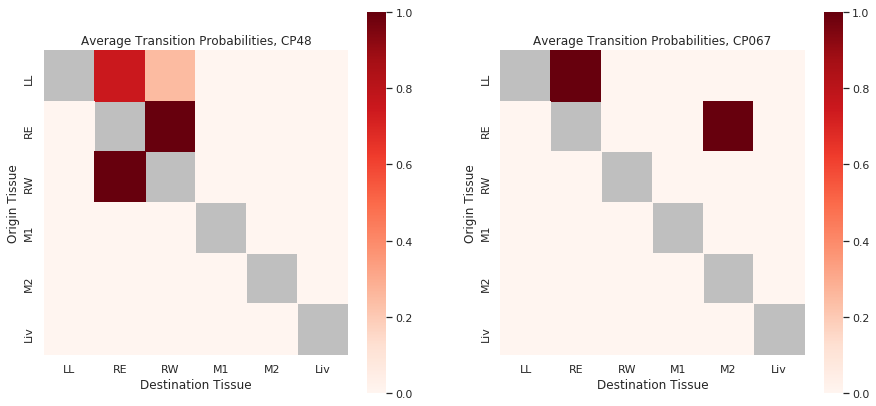

In [464]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 7))

mask = np.zeros_like(lg_to_countarr[7])
np.fill_diagonal(mask, 1)

lg1 = 48

res = lg_to_countarr[lg1].loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
g = sns.heatmap(res, mask = mask, cmap="Reds", ax=axes[0], square=True)
axes[0].set_ylabel("Origin Tissue")
axes[0].set_xlabel("Destination Tissue")
axes[0].set_title("Average Transition Probabilities, CP" + str(lg1))
g.set_facecolor('#bfbfbf')

lg2 = 67

res = lg_to_countarr[lg2].loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
g = sns.heatmap(res, mask = mask, cmap="Reds", ax=axes[1], square=True)
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Average Transition Probabilities, CP0" + str(lg2))
g.set_facecolor('#bfbfbf')

# plt.savefig("cp014_cp028_tmat.eps")


### Example for computing a subtree's transition matrix

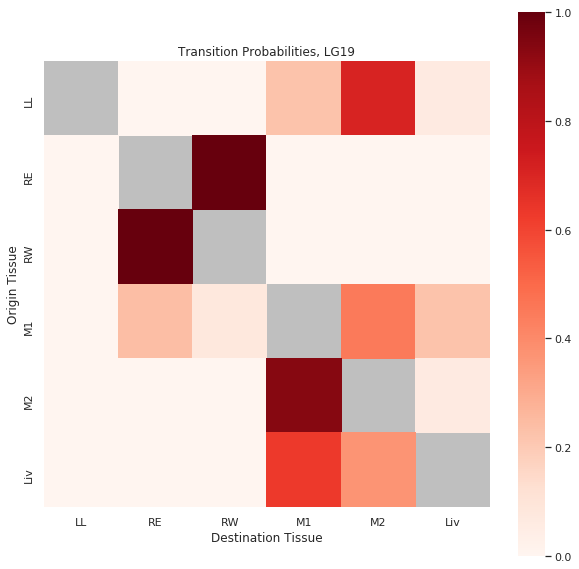

In [457]:
import cassiopeia.TreeSolver.utilities as util 

lg = lg_to_tree[19]
cm = lg_to_cm[19]

def get_leaves(tree, x):
    
    all_prog = [node for node in nx.dfs_preorder_nodes(tree, x)]
    return [n.name for n in all_prog if tree.out_degree(n) == 0 and tree.in_degree(n) == 1]
    
plg = lg.post_process(cm).network

c1 = "M2.GTGAAGGAGCTGTCTA-1"
c2 = "M2.TGCACCTCACTACAGT-1"
c3 = "M2.TCACAAGTCGGCTACG-1"
c4 = "RE.GATGAAAAGTAGCCGA-1"

root = [n for n in plg if plg.in_degree(n) == 0][0]
subns = []
plg2 = nx.DiGraph()
for child in plg.successors(root):
    all_children = get_leaves(plg, child)
    if c1 in all_children or c2 in all_children or c3 in all_children or c4 in all_children:
        subn = plg.subgraph([node for node in nx.dfs_preorder_nodes(plg, child)])
        plg2 = nx.compose(plg2, subn)

pseudo_roots = [n for n in plg2 if plg2.in_degree(n) == 0]
plg2.add_edges_from([(root, pr) for pr in pseudo_roots])

nw = util.convert_network_to_newick_format(plg2)
with open('sublg19_tree.nwk', 'w') as f:
    f.write(nw)

leaves = [n for n in plg2 if plg2.out_degree(n) == 0]

count_arr = reconstruct_states.fitch_count(plg2, lg_meta['sampleID'], count_unique=False)
np.fill_diagonal(count_arr.values,0)

mask = np.zeros_like(lg_to_countarr[7])
np.fill_diagonal(mask, 1)

count_arr = count_arr.apply(lambda x: x / max(1, x.sum()), axis=1)
res = count_arr.loc[['LL', "RE", 'RW', "M1", "M2", "Liv"], ['LL', "RE", 'RW', "M1", "M2", "Liv"]]
h = plt.figure(figsize=(10, 10))
np.fill_diagonal(count_arr.values,np.nan)
g = sns.heatmap(res, mask = mask, cmap="Reds",  square=True)
plt.ylabel("Origin Tissue")
plt.xlabel("Destination Tissue")
plt.title("Transition Probabilities, LG" + str(19))
g.set_facecolor('#bfbfbf')
plt.show()